<a href="https://colab.research.google.com/github/Farii01/Internship_PINN_work/blob/main/PINN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!pip install git+https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git


  Cloning https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git to /tmp/pip-req-build-65ymb6bv
  Running command git clone --filter=blob:none --quiet https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git /tmp/pip-req-build-65ymb6bv
  Resolved https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git to commit 87d5eab82dbae0c55a8d93113cd4ac6db38a0bf0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [79]:
import pygeotools
import torch
import torch.nn as nn
import numpy as np

In [80]:
model_path = "/content/COVOBS-x2_400reals.hdf5"


In [81]:
import pygeotools

pygeo = pygeotools.pygeotools()
model_name=  "COVOBS-x2_400reals.hdf5"
pygeo.loadModel(
    modelName="COVOBS-x2_400reals.hdf5",
    modelType="covobs_hdf5",
    modelPath=model_path
)

pygeo.isLoaded("COVOBS-x2_400reals.hdf5")  # Should return True


pygeotools was initialized with `verbose=True`.


True


*   **2 Epochs**
*   **2015 data**




# **Familiarizing with pygeo**

In [82]:
dir(pygeo)


['Error',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_pygeotools__colors',
 '_pygeotools__computedOperators',
 '_pygeotools__figures',
 '_pygeotools__gridTypes',
 '_pygeotools__grids',
 '_pygeotools__modelTypes',
 '_pygeotools__numericalCostLimit',
 '_pygeotools__numericalPrecision',
 '_pygeotools__observationTypes',
 '_pygeotools__observatories',
 '_pygeotools__precisions',
 '_pygeotools__verbose',
 'addFigure',
 'addGrid',
 'addMeasure',
 'addOperator',
 'addSubplot',
 'applyPrecisio

In [83]:
help(pygeo.addMeasure)

Help on method addMeasure in module pygeotools.pygeotools:

addMeasure(modelName: str, measureName: str, context={}) -> numpy.ndarray method of pygeotools.pygeotools.pygeotools instance
    # Adding a measure with a specific context



In [84]:
help(pygeo.getQuantities) # What the function expects, What it returns, What we can do with it


Help on method getQuantities in module pygeotools.pygeotools:

getQuantities(modelName: str) -> set method of pygeotools.pygeotools.pygeotools instance
    # Retrieving the available quantities of a model



In [85]:
pygeo[model_name].keys() # what is inside models


dict_keys(['type', 'path', 'quantities', 'measures'])

In [86]:
pygeo[model_name]['quantities'].keys()# inside quantities in models

dict_keys(['dgnm', 'dq10', 'gnm', 'q10', 'times'])

In [87]:
pygeo.getQuantities(model_name)


dict_keys(['dgnm', 'dq10', 'gnm', 'q10', 'times'])

In [88]:
# i was seeing the range
info  = pygeo.getQuantity(model_name, "times")
print(f"Model covers from {info .min()} to {info.max()}")


Model covers from 1840.0 to 2022.0


In [89]:
times = pygeo.getQuantity(model_name, "times")
print(times[0:1])

[1840.]


Focusing from

In [90]:


context = {
    "r": pygeo.constants["rCore"],  # not rEarth
    "lmax": 14
}


# Compute measures: Br (MF) and dBr/dt (SV). u.
pygeo.addMeasure(modelName=model_name, measureName="MF", context= context) # theta phy br
pygeo.addMeasure(modelName=model_name, measureName="SV", context=context) # the phi and the change in br

MF = pygeo.getMeasure(model_name, "MF", context=context)
SV = pygeo.getMeasure(model_name, "SV", context=context)

14


In [91]:
import torch
import torch.nn as nn

#  3-layer NN: 2x32 → 32x32 → 32x2
class CoreFlowPINN(nn.Module):
    def __init__(self):
        super(CoreFlowPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2)  # Output: u_theta and u_phi
        )

    def forward(self, x):
        return self.net(x)


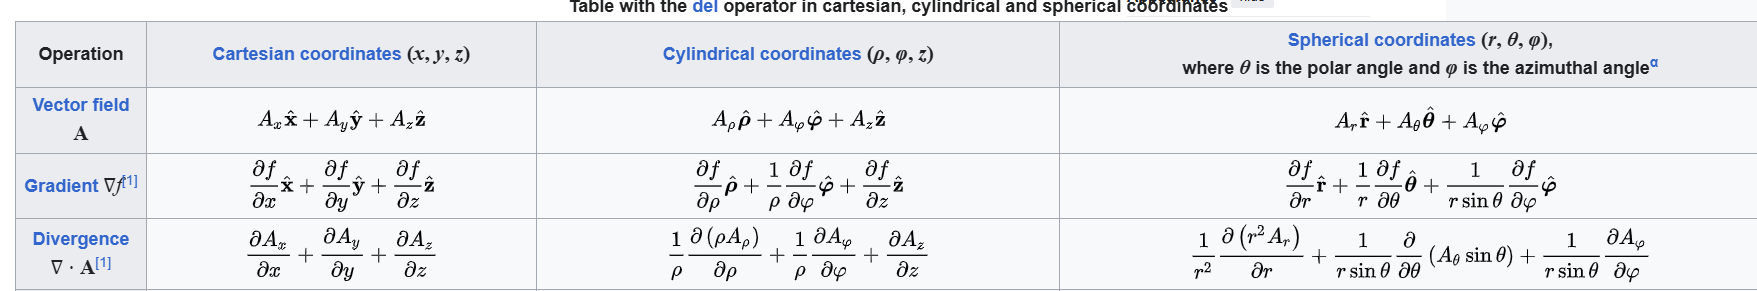

In [98]:
find_years = range(2020, 2026)
years = pygeo.getQuantity(model_name, "times")

'''
pygeo.selectFromMeasure(
 modelName="CHAOS",
 measure=MF,
 options={
        "time": (2000, 2010),
        "theta": (90, 180),
        "phi": (0, 270)
 }
)
'''

loss_history_by_year = {}

for year in find_years:
    if year in years:

        #fetching magnetic field of my specified time range
        mf_grid = pygeo.selectFromMeasure(
            modelName=model_name,
            measure=MF,
            options={"time": (year, year)}
        )

        sv_grid = pygeo.selectFromMeasure(
            modelName=model_name,
            measure=SV,
            options={"time": (year, year)}
        )

        print(f"\nData loaded for year {year}\n")

        # Convert data to numpy and reshape to [theta, phi, value]
        mf_np = np.array(mf_grid).reshape(-1, 3) #[θ,φ,B]
        sv_np = np.array(sv_grid).reshape(-1, 3) #[θ,φ,dBr/dt]

        # Convert to torch tensors with gradients enabled for theta and phi
        theta = torch.tensor(mf_np[:, 0:1], dtype=torch.float32, requires_grad=True)
        phi   = torch.tensor(mf_np[:, 1:2], dtype=torch.float32, requires_grad=True)
        Br    = torch.tensor(mf_np[:, 2:3], dtype=torch.float32)
        dBr_dt = torch.tensor(sv_np[:, 2:3], dtype=torch.float32)

        # Concatenate theta and phi as input to the PINN
        inputs = torch.cat([theta, phi], dim=1)

        # Reinitialize the model and optimizer for each year
        model = CoreFlowPINN()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        loss_history = []

        # Training loop
        for epoch in range(1000):
            optimizer.zero_grad()

            # Predict u_theta and u_phi using the PINN
            u_pred = model(inputs)
            u_theta = u_pred[:, 0:1]
            u_phi   = u_pred[:, 1:2]

            # to calculate divergence according to image above
            q_theta = u_theta * Br #A theta
            q_phi   = u_phi * Br   # A phi

            q_theta_sin = q_theta * torch.sin(theta)

            dq_theta_sin_dtheta = torch.autograd.grad(
                q_theta_sin, theta,
                grad_outputs=torch.ones_like(q_theta_sin),
                create_graph=True, retain_graph=True
            )[0]

            dq_phi_dphi = torch.autograd.grad(
                q_phi, phi,
                grad_outputs=torch.ones_like(q_phi),
                create_graph=True, retain_graph=True
            )[0]

            divergence = (1 / (r * torch.sin(theta))) * (
                dq_theta_sin_dtheta + dq_phi_dphi
            )

            # testing
            residual = dBr_dt + divergence
            loss = torch.mean(residual ** 2)

            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())

            print(f"{year} : Epoch {epoch} --- Loss {loss.item():.6f}")

        loss_history_by_year[year] = loss_history

    else:
        print(f"\nNo data available for year {year}")



Data loaded for year 2020

2020 : Epoch 0 --- Loss 15183551.000000
2020 : Epoch 1 --- Loss 15176184.000000
2020 : Epoch 2 --- Loss 15170585.000000
2020 : Epoch 3 --- Loss 15166327.000000
2020 : Epoch 4 --- Loss 15163125.000000
2020 : Epoch 5 --- Loss 15160851.000000
2020 : Epoch 6 --- Loss 15159324.000000
2020 : Epoch 7 --- Loss 15158409.000000
2020 : Epoch 8 --- Loss 15157931.000000
2020 : Epoch 9 --- Loss 15157510.000000
2020 : Epoch 10 --- Loss 15157112.000000
2020 : Epoch 11 --- Loss 15156562.000000
2020 : Epoch 12 --- Loss 15155842.000000
2020 : Epoch 13 --- Loss 15154947.000000
2020 : Epoch 14 --- Loss 15153961.000000
2020 : Epoch 15 --- Loss 15152918.000000
2020 : Epoch 16 --- Loss 15151814.000000
2020 : Epoch 17 --- Loss 15150756.000000
2020 : Epoch 18 --- Loss 15149789.000000
2020 : Epoch 19 --- Loss 15148941.000000
2020 : Epoch 20 --- Loss 15148195.000000
2020 : Epoch 21 --- Loss 15147678.000000
2020 : Epoch 22 --- Loss 15147141.000000
2020 : Epoch 23 --- Loss 15146597.00000

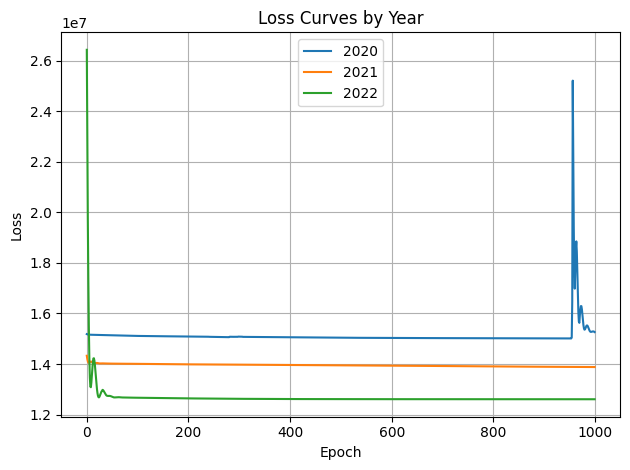

In [99]:
import matplotlib.pyplot as plt

for year, losses in loss_history_by_year.items():
    plt.plot(losses, label=f"{year}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves by Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

